# Property Analysis for Single Family Home Purchase

This notebook analyzes property data to identify properties that fit defined criteria and ranks them based on desirability and seller likelihood.

## 1. Setup and Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import re


# Enable interactive plots
%matplotlib inline


# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]


# Set display options to see more columns
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)


# Print version info
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Pandas version: 2.2.2
NumPy version: 1.26.4
Matplotlib version: 3.9.2
Seaborn version: 0.13.2


## 2. Load The Data

Load the property data, with an option to test on a small subset first.

In [23]:
def load_data(file_path):
    """
    Load and clean property data from CSV file.
    
    Args:
        file_path (str): Path to the CSV file
        
    Returns:
        pandas.DataFrame: Cleaned property data
    """
    print(f"Loading data from {file_path}...")
    
    # Use dtype parameter to specify data types upfront for more efficient loading
    # Also use low_memory=False to avoid mixed type inference warnings
    dtypes = {
        'SiteZIP': str,
        'LandUseDsc': str
    }
    
    properties = pd.read_csv(file_path, dtype=dtypes, low_memory=False)
    print(f"Original data shape: {properties.shape}")
    
    # Convert date columns - with a specific format for efficiency
    if 'DocRcrdgDt_County' in properties.columns:
        properties['DocRcrdgDt_County'] = pd.to_datetime(
            properties['DocRcrdgDt_County'], errors='coerce', format='%Y-%m-%d'
        )
    
    # Use vectorized operations instead of astype+str+replace chain
    currency_columns = [
        'MktTtlVal', 'SaleAmt_County', 'TaxTtl1', 'TaxTtl2', 'TaxTtl3'
    ]
    for col in currency_columns:
        if col in properties.columns:
            # This is more efficient than the chain of operations
            properties[col] = pd.to_numeric(
                properties[col].astype(str).str.replace(r'[\$,]', '', regex=True),
                errors='coerce'
            )
    
    # Handle other numeric columns in a batch when possible
    other_numeric_columns = [
        'BsmtFinSqFt', 'BsmtUnFinSqFt', 'BathHalfCt', 'Bath3QtrCt',
        'BathFullCt', 'BathTtlCt', 'BedCt', 'BldgSqFt', 'LotSqFt',
        'YrBlt', 'StoriesCt', 'Acres'
    ]
    
    # Check which columns exist first
    existing_num_cols = [col for col in other_numeric_columns if col in properties.columns]
    if existing_num_cols:
        properties[existing_num_cols] = properties[existing_num_cols].apply(
            pd.to_numeric, errors='coerce'
        )
    
    # Use boolean conversion directly where possible
    boolean_columns = [
        'OwnerOccupiedInd', 'BareLandInd', 'InvestmentProp', 
        'BankOwnedInd', 'OwnerCorporateInd'
    ]
    for col in boolean_columns:
        if col in properties.columns:
            properties[col] = properties[col].map({
                'TRUE': True, 'FALSE': False, True: True, False: False
            })
    
    print(f"Cleaned data shape: {properties.shape}")
    print(f"Sample market values: {properties['MktTtlVal'].dropna().head().tolist()}")
    
    return properties

### 3. Data Loading Function

Define a function to load and clean the property data CSV.

In [24]:
# Set path to your data file
file_path = "../data/Category_3.csv"

# Load and clean data
properties = load_data(file_path)

Loading data from ../data/Category_3.csv...
Original data shape: (886, 147)
Cleaned data shape: (886, 147)
Sample market values: [561000.0, 622000.0, 600000.0, 555000.0, 649000.0]


## 4. Examine the Data

Let's examine the data to understand what we're working with.

In [25]:
# Display a few sample rows
properties.head()

,ParcelId,OwnerNmFirstBoth,OwnerNmLast,SiteAddr,SiteCity,SiteState,SiteZIP,SiteZipFull,SiteZIPPlus4,SiteCarrierCd,OwnerAddr,OwnerCityNm,OwnerZIP,OwnerState,OwnerCntryNm,OwnerZipFull,OwnerZIPPlus4,Acres,AssdImprVal,AssdLandVal,AssdTtlVal,AssmtYr,AssrMapLnk,BareLandInd,BsmtFinSqFt,...,TaxTtl3,TaxYr1,TaxYr2,TaxYr3,TaxAcctNum,TaxPyrAddr,TaxPyrCntryNm,TaxPyrNmFirst,TaxPyrNmLast,TaxPyrNm,TaxPyrState,TaxPyrZIP,Twn,TRS,UnfinTtlSqFt,SiteUnit,ViewDsc,WtrSrc,WtrfntNm,WtrfntFt,WtrshdCd,WtrshdDsc,YrBlt,ZoneCd,ZoneDsc
0,34001880,NaN,Mandin Family Living Trust,8225 California Ave SW,Seattle,WA,98136,98136-2320,2320.0,C066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0992,"$233,000.00","$328,000.00","$561,000.00",2025,/FileService/FlatFile/WA/King/0034001880/1,False,0,...,5261.49,2025,2024,2023,3400188003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24N,24N03E35,0,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1941,Seattle-NR3,Residential Neighborhood 3
1,37000120,Michael,Melake,3732 SW 99th St,Seattle,WA,98126,98126-4026,4026.0,C071,3732 SW 99th St,Seattle,98126.0,WA,NaN,98126-4026,4026.0,0.1221,"$240,000.00","$382,000.00","$622,000.00",2025,/FileService/FlatFile/WA/King/0037000120/1,False,0,...,5494.86,2025,2024,2023,3700012002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23N,23N03E02,0,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1966,Seattle-NR3,Residential Neighborhood 3
2,37000195,Elizabeth & Ha,Mash,3525 SW 98th St,Seattle,WA,98126,98126-4019,4019.0,C071,3525 SW 98th St,Seattle,98126.0,WA,NaN,98126-4019,4019.0,0.1221,"$218,000.00","$382,000.00","$600,000.00",2025,/FileService/FlatFile/WA/King/0037000195/1,False,490,...,5251.29,2025,2024,2023,3700019502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23N,23N03E02,280,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1947,Seattle-NR3,Residential Neighborhood 3
3,37000515,James & Carri,Rachogan,3745 SW 99th St,Seattle,WA,98126,98126-4025,4025.0,C071,3745 SW 99th St,Seattle,98126.0,WA,NaN,98126-4025,4025.0,0.1832,"$80,000.00","$475,000.00","$555,000.00",2025,/FileService/FlatFile/WA/King/0037000515/1,False,600,...,5669.89,2025,2024,2023,3700051505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23N,23N03E02,60,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1937,Seattle-NR3,Residential Neighborhood 3
4,37000575,Jason,Guild,3709 SW 99th St,Seattle,WA,98126,98126-4025,4025.0,C071,3709 SW 99th St,Seattle,98126.0,WA,NaN,98126-4025,4025.0,0.1221,"$267,000.00","$382,000.00","$649,000.00",2025,/FileService/FlatFile/WA/King/0037000575/1,False,0,...,5795.26,2025,2024,2023,3700057502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23N,23N03E02,0,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1968,Seattle-NR3,Residential Neighborhood 3


In [26]:
# Check data types and missing values
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Columns: 147 entries, ParcelId to ZoneDsc
dtypes: bool(6), datetime64[ns](1), float64(30), int64(46), object(64)
memory usage: 981.3+ KB


In [27]:
# Look at statistics for numeric columns
properties.describe()

,ParcelId,SiteZIPPlus4,OwnerZIP,OwnerCntryNm,OwnerZIPPlus4,Acres,AssmtYr,BsmtFinSqFt,BsmtUnFinSqFt,BathHalfCt,Bath3QtrCt,BathFullCt,BathTtlCt,BedCt,BldgCt,BldgSqFt,CensBlock,CensTract,ComTtlSqFt,ComUseDsc,CompletePct,CondoLevel,CondoNm,CondoUnitCt,ConstTypeDsc,...,DocRcrdgDt_County,SaleAmt_County,SchDistCd,Sec,StoriesCt,TCA,TaxTtl1,TaxTtl2,TaxTtl3,TaxYr1,TaxYr2,TaxYr3,TaxAcctNum,TaxPyrAddr,TaxPyrCntryNm,TaxPyrNmFirst,TaxPyrNmLast,TaxPyrNm,TaxPyrState,TaxPyrZIP,UnfinTtlSqFt,SiteUnit,WtrfntFt,WtrshdCd,YrBlt
count,8.860000e+02,882.000000,885.000000,0.0,848.000000,886.000000,886.0,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.0,0.0,886.000000,0.0,0.0,886.0,0.0,...,0,8.860000e+02,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.0,886.0,886.0,8.860000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,886.000000,0.0,886.000000,8.860000e+02,886.000000
mean,4.881680e+09,2418.785714,97619.515254,NaN,2587.002358,0.146887,2025.0,308.559819,258.493228,0.384876,0.434537,1.305869,1.824210,3.186230,1.001129,1716.079007,2318.411964,12043.584650,0.0,NaN,0.136569,NaN,NaN,0.0,NaN,...,NaT,2.579856e+05,24.927765,26.413093,1.144470,239.262980,5768.480034,5382.395598,5219.704176,2025.0,2024.0,2023.0,4.881680e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.493228,NaN,0.058691,1.711002e+09,1954.332957
min,3.400188e+07,1102.000000,10463.000000,NaN,1102.000000,0.032500,2025.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,2.000000,1.000000,1000.000000,1000.000000,9600.000000,0.0,NaN,0.000000,NaN,NaN,0.0,NaN,...,NaT,0.000000e+00,1.000000,1.000000,1.000000,10.000000,850.410000,725.150000,12.210000,2025.0,2024.0,2023.0,3.400188e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,1.711001e+09,1905.000000
25%,2.695600e+09,1810.250000,98106.000000,NaN,1840.750000,0.114325,2025.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.500000,3.000000,1.000000,1332.500000,2000.000000,10800.000000,0.0,NaN,0.000000,NaN,NaN,0.0,NaN,...,NaT,8.723750e+04,1.000000,24.000000,1.000000,10.000000,5870.695000,5364.015000,5141.212500,2025.0,2024.0,2023.0,2.695600e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,1.711002e+09,1937.000000
50%,4.302200e+09,2332.500000,98106.000000,NaN,2428.000000,0.136000,2025.0,165.000000,0.000000,0.000000,0.000000,1.000000,1.750000,3.000000,1.000000,1660.000000,2009.000000,11300.000000,0.0,NaN,0.000000,NaN,NaN,0.0,NaN,...,NaT,2.205000e+05,1.000000,30.000000,1.000000,10.000000,6319.050000,5766.560000,5498.955000,2025.0,2024.0,2023.0,4.302200e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,1.711002e+09,1954.000000
75%,7.899800e+09,2914.000000,98126.000000,NaN,2968.000000,0.173600,2025.0,600.000000,497.500000,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,2080.000000,3009.000000,11402.000000,0.0,NaN,0.000000,NaN,NaN,0.0,NaN,...,NaT,3.947500e+05,1.000000,35.000000,1.000000,10.000000,6601.145000,6023.300000,5746.547500,2025.0,2024.0,2023.0,7.899800e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,497.500000,NaN,0.000000,1.711002e+09,1977.000000
max,9.842301e+09,4319.000000,98922.000000,NaN,9685.000000,1.050000,2025.0,1720.000000,1440.000000,2.000000,2.000000,3.000000,3.500000,6.000000,2.000000,2960.000000,5015.000000,26600.000000,0.0,NaN,60.000000,NaN,NaN,0.0,NaN,...,NaT,1.041900e+06,401.000000,36.000000,2.000000,3850.000000,7604.730000,7322.920000,7270.610000,2025.0,2024.0,2023.0,9.842301e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1440.000000,NaN,52.000000,1.711002e+09,2024.000000
std,2.756360e+09,754.162813,5231.349082,NaN,1074.435467,0.064578,0.0,351.145966,317.316633,0.500573,0.531178,0.518701,0.357618,0.730507,0.033596,453.869809,1032.898542,3767.872508,0.0,NaN,2.499373,NaN,NaN,0.0,NaN,...,NaN,2.164309e+05,94.914362,9.404459,0.308098,909.255501,1557.285702,1266.269365,1103.524581,0.0,0.0,0.0,2.756360e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.316633,NaN,1.746974,2.396397e+02,24.808482


In [28]:
# Check which ZIP codes are present
if 'SiteZIP' in properties.columns:
    print("ZIP code counts:")
    print(properties['SiteZIP'].value_counts())

ZIP code counts:
SiteZIP
98106    627
98126    190
98136     46
98116     23
Name: count, dtype: int64


In [29]:
# Check distribution of property types
if 'LandUseDsc' in properties.columns:
    print("Land use types:")
    print(properties['LandUseDsc'].value_counts().head(10))

Land use types:
LandUseDsc
Single Family(Res Use/Zone)    886
Name: count, dtype: int64


## 5. Filter Functions

Define functions to filter properties based on our criteria.

In [30]:
def filter_category3(properties):
    """
    Apply Category 3 (Single-Family Residences) filters
    
    Args:
        properties (pandas.DataFrame): Property data
        
    Returns:
        pandas.DataFrame: Filtered property data
    """
    print("Filtering for Category 3 (Single-Family Residences) with criteria:")
    print("  - At least 1.5 bathrooms")
    print("  - At least 2 bedrooms")
    print("  - In ZIP codes: 98106, 98116, 98126, 98136")
    print("  - Market value between $450,000-$650,000")
    print("  - Property type: Single Family")

    # Normalize key fields
    if 'SiteZIP' in properties.columns:
        properties['SiteZIP'] = properties['SiteZIP'].astype(str).str.strip()
    
    if 'LandUseDsc' in properties.columns:
        properties['LandUseDsc'] = properties['LandUseDsc'].astype(str).str.strip()

    category3_filter = (
        (properties['BathTtlCt'] >= 1.5) &
        (properties['BedCt'] >= 2) &
        (properties['SiteZIP'].isin(['98106', '98116', '98126', '98136'])) &
        (properties['MktTtlVal'] >= 450000) &
        (properties['MktTtlVal'] <= 650000) &
        (properties['LandUseDsc'].str.contains('Single Family', case=False, na=False))
    )

    cat3_properties = properties[category3_filter].copy()

    print(f"Found {len(cat3_properties)} properties matching Category 3 criteria out of {len(properties)} total properties")
    
    if len(cat3_properties) > 0:
        print("\nBreakdown by ZIP code:")
        print(cat3_properties['SiteZIP'].value_counts())

    return cat3_properties

def calculate_zip_averages(properties):
    """
    Calculate average values by ZIP code
    
    Args:
        properties (pandas.DataFrame): Property data
        
    Returns:
        pandas.DataFrame: Average values by ZIP code
    """
    zip_averages = properties.groupby('SiteZIP')['MktTtlVal'].mean().reset_index()
    zip_averages.rename(columns={'MktTtlVal': 'ZipAvgValue'}, inplace=True)
    
    print("ZIP code average values:")
    print(zip_averages)
    
    return zip_averages

## 6. Apply Filters

Let's apply the filters and see what properties match our criteria.

In [31]:
# Apply Category 3 filters
cat3_properties = filter_category3(properties)


# Display the first few properties that match
if len(cat3_properties) > 0:
    # Select a subset of columns to display
    display_columns = [
        'SiteAddr', 'SiteCity', 'SiteZIP', 'BathTtlCt', 'BedCt',
        'BldgSqFt', 'LotSqFt', 'YrBlt', 'MktTtlVal', 'LandUseDsc'
    ]
    
    # Make sure all requested columns exist
    display_columns = [col for col in display_columns if col in cat3_properties.columns]
    
    print("\nSample of matching Category 3 properties:")
    display(cat3_properties[display_columns].head())
else:
    print("\nNo properties match Category 3 criteria.")


# Calculate neighborhood averages
if len(cat3_properties) > 0:
    zip_averages = calculate_zip_averages(cat3_properties)
    
    # Merge with the properties dataframe
    cat3_properties = cat3_properties.merge(zip_averages, on='SiteZIP', how='left')

Filtering for Category 3 (Single-Family Residences) with criteria:
  - At least 1.5 bathrooms
  - At least 2 bedrooms
  - In ZIP codes: 98106, 98116, 98126, 98136
  - Market value between $450,000-$650,000
  - Property type: Single Family
Found 803 properties matching Category 3 criteria out of 886 total properties

Breakdown by ZIP code:
SiteZIP
98106    590
98126    168
98136     36
98116      9
Name: count, dtype: int64

Sample of matching Category 3 properties:


,SiteAddr,SiteCity,SiteZIP,BathTtlCt,BedCt,BldgSqFt,LotSqFt,YrBlt,MktTtlVal,LandUseDsc
0,8225 California Ave SW,Seattle,98136,1.75,3,1000,4320,1941,561000.0,Single Family(Res Use/Zone)
1,3732 SW 99th St,Seattle,98126,1.50,3,1200,5320,1966,622000.0,Single Family(Res Use/Zone)
2,3525 SW 98th St,Seattle,98126,1.50,4,1910,5320,1947,600000.0,Single Family(Res Use/Zone)
3,3745 SW 99th St,Seattle,98126,2.00,4,1320,7980,1937,555000.0,Single Family(Res Use/Zone)
4,3709 SW 99th St,Seattle,98126,1.50,3,1390,5320,1968,649000.0,Single Family(Res Use/Zone)


ZIP code average values:
  SiteZIP    ZipAvgValue
0   98106  594623.728814
1   98116  615444.444444
2   98126  609535.714286
3   98136  605638.888889


## 7. Exploratory Data Analysis

Let's visualize some aspects of the filtered properties to better understand them.

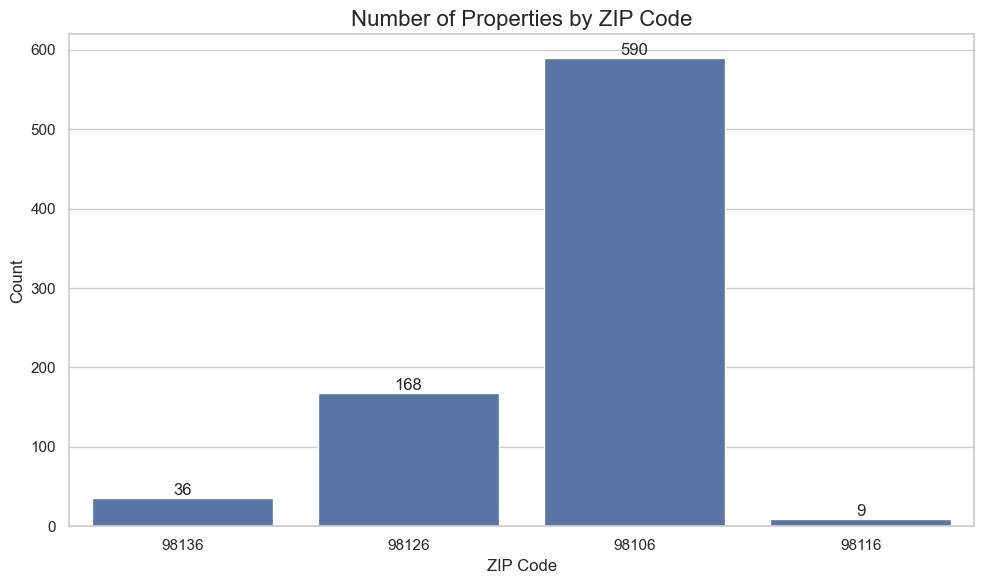

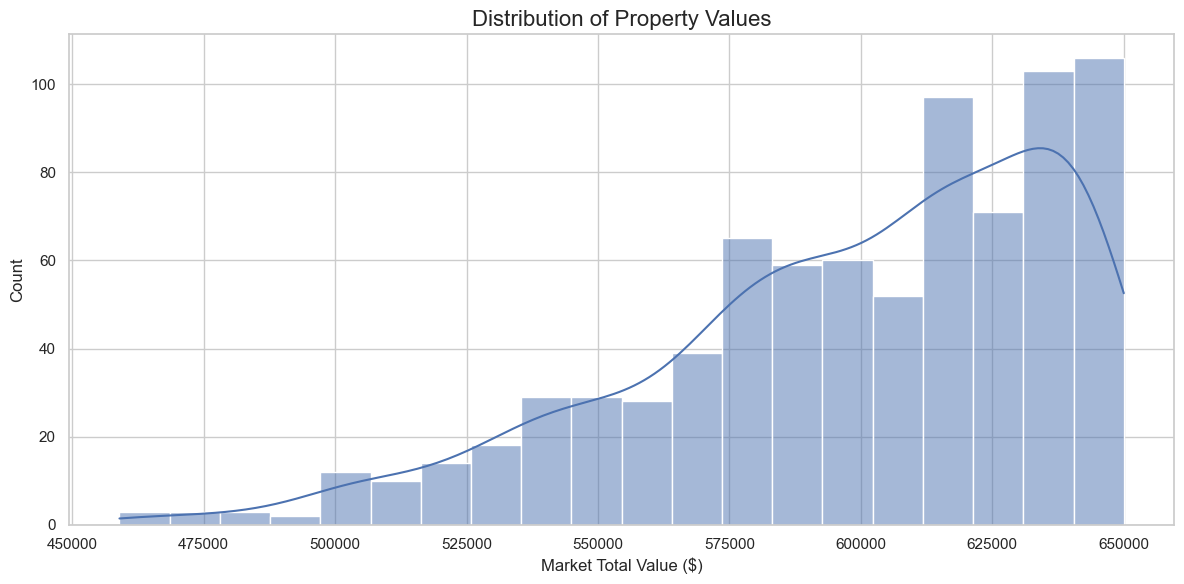

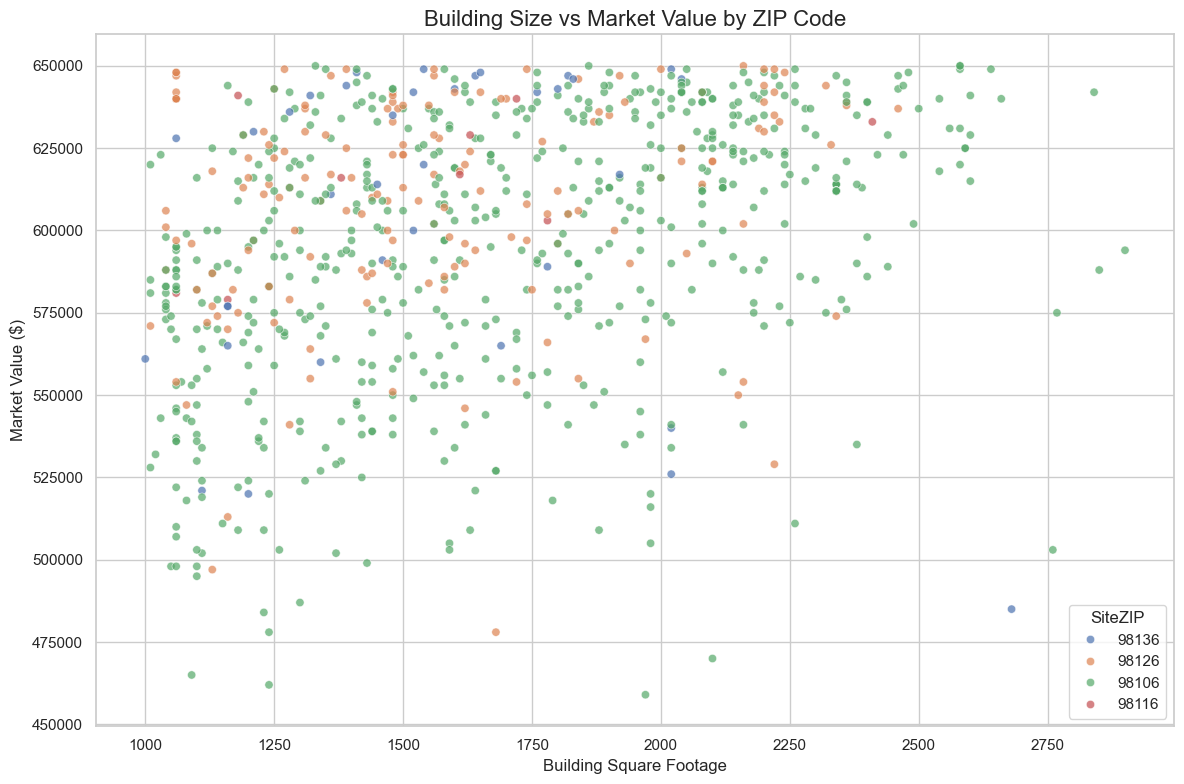

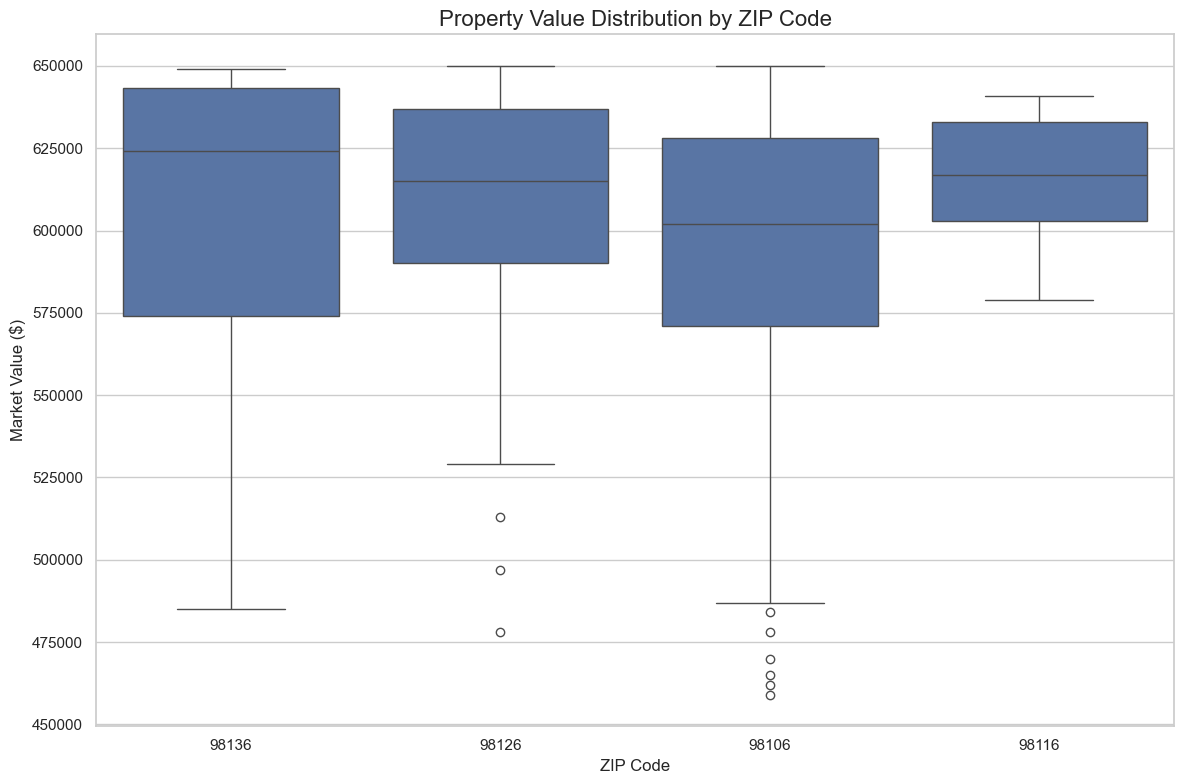

In [32]:
# Only run if we have matching properties
if len(cat3_properties) > 0:
    # Distribution of properties by ZIP code
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=cat3_properties, x='SiteZIP')
    plt.title('Number of Properties by ZIP Code', fontsize=16)
    plt.xlabel('ZIP Code', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Add counts on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Distribution of property values
    plt.figure(figsize=(12, 6))
    sns.histplot(cat3_properties['MktTtlVal'], bins=20, kde=True)
    plt.title('Distribution of Property Values', fontsize=16)
    plt.xlabel('Market Total Value ($)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Building Size vs Market Value
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=cat3_properties, x='BldgSqFt', y='MktTtlVal', hue='SiteZIP', alpha=0.7)
    plt.title('Building Size vs Market Value by ZIP Code', fontsize=16)
    plt.xlabel('Building Square Footage', fontsize=12)
    plt.ylabel('Market Value ($)', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Boxplot of property values by ZIP code
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=cat3_properties, x='SiteZIP', y='MktTtlVal')
    plt.title('Property Value Distribution by ZIP Code', fontsize=16)
    plt.xlabel('ZIP Code', fontsize=12)
    plt.ylabel('Market Value ($)', fontsize=12)
    plt.tight_layout()
    plt.show()

## 8. Scoring Functions - Desirability - Category 3

Now let's define functions to scorecat3 each property on desirability factors.

In [33]:
#========== DESIRABILITY SCORE FUNCTIONS - CATEGORY 3 ==========


def calculate_property_type_scorecat3(row):
    """
    Calculate property type scorecat3 (15 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-15
    """
    if (pd.notna(row['LandUseDsc']) and "Single Family" in str(row['LandUseDsc']) and 
          pd.notna(row['Condition']) and str(row['Condition']).strip().lower() in ['good', 'excellent']):
        return 15
    elif (pd.notna(row['LandUseDsc']) and "Single Family" in str(row['LandUseDsc']) and 
          pd.notna(row['Condition']) and str(row['Condition']).strip().lower() == 'average'):
        return 12
    elif pd.notna(row['LandUseDsc']) and "Single Family" in str(row['LandUseDsc']):
        return 8
    else:
        return 0


def calculate_bathroom_distribution_scorecat3(row):
    """
    Calculate bathroom distribution scorecat3 (15 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-15
    """
    bath_full = row['BathFullCt'] if pd.notna(row['BathFullCt']) else 0
    bath_3qtr = row['Bath3QtrCt'] if pd.notna(row['Bath3QtrCt']) else 0
    bath_half = row['BathHalfCt'] if pd.notna(row['BathHalfCt']) else 0
    
    # For personal residence, convenience and comfort are key
    if bath_full >= 1 and (bath_3qtr >= 1 or bath_half >= 1):
        return 15
    elif bath_full >= 1:
        return 10
    elif bath_3qtr >= 1:
        return 8
    else:
        return 5


def calculate_building_size_scorecat3(row):
    """
    Calculate building size scorecat3 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-10
    """
    # For single-family residence, focus on "right-sized" homes
    if pd.notna(row['BldgSqFt']):
        if 1800 <= row['BldgSqFt'] <= 2500:
            return 10  # Ideal size range
        elif 1500 <= row['BldgSqFt'] < 1800:
            return 8   # Still comfortable
        elif 2500 < row['BldgSqFt'] <= 3000:
            return 6   # Larger but potentially higher maintenance
        elif 1200 <= row['BldgSqFt'] < 1500:
            return 4   # Smaller but workable
        else:
            return 2   # Either too small or too large
    return 0


def calculate_basement_space_scorecat3(row):
    """
    Calculate basement space scorecat3 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-10
    """
    bsmt_fin = row['BsmtFinSqFt'] if pd.notna(row['BsmtFinSqFt']) else 0
    bsmt_unfin = row['BsmtUnFinSqFt'] if pd.notna(row['BsmtUnFinSqFt']) else 0
    
    # For personal residence, mixed use is valuable
    if bsmt_fin >= 500 and bsmt_unfin >= 200:
        return 10  # Ideal mix of finished living space and storage/workshop
    elif bsmt_fin >= 600:
        return 8   # Good living space
    elif bsmt_unfin >= 600:
        return 6   # Good potential for workshop/storage
    elif (bsmt_fin + bsmt_unfin) > 300:
        return 4   # Some basement is better than none
    else:
        return 0   # No significant basement
    return 0


def calculate_stories_count_scorecat3(row):
    """
    Calculate stories count scorecat3 (5 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-5
    """
    # For single-family, single-story or 1.5 story may be preferred
    if pd.notna(row['StoriesCt']):
        if row['StoriesCt'] == 1:
            return 5  # Single-story for accessibility
        elif row['StoriesCt'] == 1.5:
            return 4  # Good compromise
        elif row['StoriesCt'] == 2:
            return 3  # Traditional two-story
        else:
            return 1  # More than 2 stories may be less desirable
    return 1


def calculate_zip_code_value_scorecat3(row):
    """
    Calculate ZIP code value scorecat3 (15 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-15
    """
    # For single-family residence, consider neighborhood quality and amenities
    if pd.notna(row['SiteZIP']):
        if row['SiteZIP'] == '98116':
            return 15  # Best schools, walkability, and amenities
        elif row['SiteZIP'] == '98136':
            return 13  # Good access to beach, parks
        elif row['SiteZIP'] == '98126':
            return 10  # Good value, improving area
        elif row['SiteZIP'] == '98106':
            return 8   # More affordable, some amenities
        else:
            return 5
    return 5


def calculate_lot_size_scorecat3(row):
    """
    Calculate lot size scorecat3 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-10
    """
    # For personal residence, moderate lots are easier to maintain
    if pd.notna(row['LotSqFt']):
        if 5000 <= row['LotSqFt'] <= 7500:
            return 10  # Ideal balance of space and maintenance
        elif 7500 < row['LotSqFt'] <= 9000:
            return 8   # Larger yard, more maintenance
        elif 4000 <= row['LotSqFt'] < 5000:
            return 6   # Smaller but manageable
        elif row['LotSqFt'] > 9000:
            return 4   # Very large lot, significant maintenance
        else:
            return 2   # Very small lot
    return 0


def calculate_condition_scorecat3(row):
    """
    Calculate condition scorecat3 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-10
    """
    # For personal residence, better condition means less immediate work
    if pd.notna(row['Condition']):
        condition = str(row['Condition']).strip().lower()
        if condition == 'excellent':
            return 10  # Move-in ready
        elif condition == 'good':
            return 8   # Minor updates needed
        elif condition == 'average':
            return 6   # Some work required
        elif condition == 'fair':
            return 4   # Significant work needed
        else:
            return 2   # Major renovation required
    return 0


def calculate_year_built_scorecat3(row):
    """
    Calculate year built scorecat3 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-10
    """
    # For personal residence, newer is generally better
    if pd.notna(row['YrBlt']):
        if row['YrBlt'] >= 2000:
            return 10  # Modern construction
        elif row['YrBlt'] >= 1980:
            return 8   # Relatively modern
        elif row['YrBlt'] >= 1960:
            return 6   # Mid-century
        elif row['YrBlt'] >= 1940:
            return 4   # Post-war
        else:
            return 2   # Very old, may have infrastructure issues
    return 0


def calculate_garage_scorecat3(row):
    """
    Calculate garage scorecat3 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat3 between 0-10
    """
    # New score factor for personal garage/storage preferences
    if pd.notna(row['GarageDsc']):
        garage_desc = str(row['GarageDsc']).strip().lower()
        
        if 'attached' in garage_desc and pd.notna(row['GarageSqFt']) and row['GarageSqFt'] >= 400:
            return 10  # Attached garage with good space
        elif 'attached' in garage_desc:
            return 8   # Any attached garage
        elif 'detached' in garage_desc and pd.notna(row['GarageSqFt']) and row['GarageSqFt'] >= 400:
            return 7   # Detached garage with good space
        elif 'detached' in garage_desc:
            return 6   # Any detached garage
        elif 'carport' in garage_desc:
            return 4   # Carport
        else:
            return 2   # Has something, but unclear what
    else:
        return 0   # No garage

In [43]:
# Test these functions on a sample property to see if they work as expected
def test_desirability_scoring_functions():
    # Create a sample property for testing
    sample_property = pd.Series({
        'LandUseDsc': 'Single Family(Res Use/Zone)',
        'BsmtFinSqFt': 700,
        'BsmtUnFinSqFt': 500,
        'BathFullCt': 2,
        'Bath3QtrCt': 1,
        'BathHalfCt': 0,
        'BldgSqFt': 2200,
        'StoriesCt': 1,
        'SiteZIP': '98126',
        'LotSqFt': 7000,
        'Condition': 'Good',
        'YrBlt': 1985
    })
    
    # Test each scoring function
    print("Testing desirability scoring functions on sample property...")
    print(f"Property Type ScoreCat3: {calculate_property_type_scorecat3(sample_property)}")
    print(f"Bathroom Distribution ScoreCat3: {calculate_bathroom_distribution_scorecat3(sample_property)}")
    print(f"Building Size ScoreCat3: {calculate_building_size_scorecat3(sample_property)}")
    print(f"Basement Space ScoreCat3: {calculate_basement_space_scorecat3(sample_property)}")
    print(f"Stories Count ScoreCat3: {calculate_stories_count_scorecat3(sample_property)}")
    print(f"ZIP Code Value ScoreCat3: {calculate_zip_code_value_scorecat3(sample_property)}")
    print(f"Lot Size ScoreCat3: {calculate_lot_size_scorecat3(sample_property)}")
    print(f"Condition ScoreCat3: {calculate_condition_scorecat3(sample_property)}")
    print(f"Year Built ScoreCat3: {calculate_year_built_scorecat3(sample_property)}")
    
    # Calculate total desirability scorecat3
    total_scorecat3 = (
        calculate_property_type_scorecat3(sample_property) +
        calculate_bathroom_distribution_scorecat3(sample_property) +
        calculate_building_size_scorecat3(sample_property) +
        calculate_basement_space_scorecat3(sample_property) +
        calculate_stories_count_scorecat3(sample_property) +
        calculate_zip_code_value_scorecat3(sample_property) +
        calculate_lot_size_scorecat3(sample_property) +
        calculate_condition_scorecat3(sample_property) +
        calculate_year_built_scorecat3(sample_property)
    )
    
    print(f"Total Desirability ScoreCat3: {total_scorecat3}")




# Run the test to see if our scoring functions work correctly
test_desirability_scoring_functions()

Testing desirability scoring functions on sample property...
Property Type ScoreCat3: 15
Bathroom Distribution ScoreCat3: 15
Building Size ScoreCat3: 10
Basement Space ScoreCat3: 10
Stories Count ScoreCat3: 5
ZIP Code Value ScoreCat3: 10
Lot Size ScoreCat3: 10
Condition ScoreCat3: 8
Year Built ScoreCat3: 8
Total Desirability ScoreCat3: 91


## 9. Calculate Cat3 Seller Likelihood

Determine seller likelihood for all filtered properties.

In [47]:
def calculate_seller_likelihood_score(properties_df):
    """
    Calculate the likelihood of sellers being willing to sell their properties,
    with specific emphasis on factors relevant to single-family residence owners.
    
    Parameters:
    -----------
    properties_df : pandas DataFrame
        DataFrame containing property information
    
    Returns:
    --------
    pandas DataFrame
        Original DataFrame with added seller likelihood score and factors
    """
    # Make a copy of the dataframe to avoid modifying the original
    df = properties_df.copy()
    
    # Initialize the seller likelihood score column and factors description
    df['SellerLikelihoodScore'] = 0
    df['SellerLikelihoodFactors'] = ''

    # Ensure numeric conversion for key financial columns
    financial_columns = ['MktTtlVal', 'AssdTtlVal', 'TaxTtl1', 'TaxTtl2', 'TaxTtl3']
    for col in financial_columns:
        if col in df.columns:
            # Remove currency symbols and commas, then convert to numeric
            df[col] = pd.to_numeric(
                df[col].astype(str).str.replace(r'[\$,]', '', regex=True), 
                errors='coerce'
            )
    
    # ===== OWNERSHIP FACTORS =====
    
    # Length of ownership - properties owned longer may be more likely to sell
    if 'DocRcrdgDt_County' in df.columns:
        df['OwnershipLength'] = pd.Timestamp.now().year - pd.to_datetime(df['DocRcrdgDt_County']).dt.year
        
        # Apply scores based on ownership length
        df.loc[df['OwnershipLength'] >= 15, 'SellerLikelihoodScore'] += 18
        df.loc[(df['OwnershipLength'] >= 7) & (df['OwnershipLength'] < 15), 'SellerLikelihoodScore'] += 12
        df.loc[(df['OwnershipLength'] >= 3) & (df['OwnershipLength'] < 7), 'SellerLikelihoodScore'] += 6
        
        # Add factor descriptions
        df.loc[df['OwnershipLength'] >= 15, 'SellerLikelihoodFactors'] += 'Very long-term owner; '
        df.loc[(df['OwnershipLength'] >= 7) & (df['OwnershipLength'] < 15), 'SellerLikelihoodFactors'] += 'Long-term owner; '
    
    # Non-owner occupied properties may be more likely to sell
    # Higher weight for single-family since most are owner-occupied
    if 'OwnerOccupiedInd' in df.columns:
        df.loc[df['OwnerOccupiedInd'] == False, 'SellerLikelihoodScore'] += 20
        df.loc[df['OwnerOccupiedInd'] == False, 'SellerLikelihoodFactors'] += 'Investment property (unusual for category); '
    
    # Corporate ownership might indicate investment property
    if 'OwnerCorporateInd' in df.columns:
        df.loc[df['OwnerCorporateInd'] == True, 'SellerLikelihoodScore'] += 15
        df.loc[df['OwnerCorporateInd'] == True, 'SellerLikelihoodFactors'] += 'Corporate owner; '
    
    # Different mailing address may indicate non-local owner
    if all(col in df.columns for col in ['OwnerAddr', 'SiteAddr']):
        df['DifferentMailingAddr'] = df['OwnerAddr'] != df['SiteAddr']
        df.loc[df['DifferentMailingAddr'], 'SellerLikelihoodScore'] += 15
        df.loc[df['DifferentMailingAddr'], 'SellerLikelihoodFactors'] += 'Non-local owner; '
    
    # ===== FINANCIAL FACTORS =====
    
    # Tax assessment increases - important for all categories
    if all(col in df.columns for col in ['TaxTtl1', 'TaxTtl2', 'TaxTtl3']):
        # Convert tax columns to numeric if needed
        for col in ['TaxTtl1', 'TaxTtl2', 'TaxTtl3']:
            if df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col].str.replace(r'[\$,]', '', regex=True), errors='coerce')
        
        # Calculate year-over-year tax increases as percentage
        df['TaxChange_Recent'] = ((df['TaxTtl1'] - df['TaxTtl2']) / df['TaxTtl2'] * 100).fillna(0)
        df['TaxChange_Previous'] = ((df['TaxTtl2'] - df['TaxTtl3']) / df['TaxTtl3'] * 100).fillna(0)
        
        # Score based on tax increases (may impact owner-occupiers more)
        df.loc[df['TaxChange_Recent'] >= 15, 'SellerLikelihoodScore'] += 15
        df.loc[(df['TaxChange_Recent'] >= 10) & (df['TaxChange_Recent'] < 15), 'SellerLikelihoodScore'] += 10
        df.loc[(df['TaxChange_Recent'] >= 5) & (df['TaxChange_Recent'] < 10), 'SellerLikelihoodScore'] += 5
        
        # Consistent tax increases over multiple years
        df.loc[(df['TaxChange_Recent'] >= 8) & (df['TaxChange_Previous'] >= 8), 'SellerLikelihoodScore'] += 7
        
        # Add factor descriptions
        df.loc[df['TaxChange_Recent'] >= 15, 'SellerLikelihoodFactors'] += 'Extreme tax increase; '
        df.loc[(df['TaxChange_Recent'] >= 10) & (df['TaxChange_Recent'] < 15), 'SellerLikelihoodFactors'] += 'Significant tax increase; '
        df.loc[(df['TaxChange_Recent'] >= 5) & (df['TaxChange_Previous'] >= 5), 'SellerLikelihoodFactors'] += 'Sustained tax increases; '
    
    # Value-to-tax ratio may indicate pressure to sell
    if all(col in df.columns for col in ['MktTtlVal', 'TaxTtl1']):
        df['TaxToValueRatio'] = (df['TaxTtl1'] / df['MktTtlVal'] * 100000).fillna(0)
        
        df.loc[df['TaxToValueRatio'] > 1.5, 'SellerLikelihoodScore'] += 8
        df.loc[df['TaxToValueRatio'] > 1.5, 'SellerLikelihoodFactors'] += 'High tax burden relative to value; '
    
    # Recent market value changes may impact selling motivation
        if 'MktTtlVal' in df.columns and 'AssdTtlVal' in df.columns:
            # Safely calculate value assessment ratio
            df['ValueAssessmentRatio'] = df.apply(
                lambda row: row['MktTtlVal'] / row['AssdTtlVal'] if row['AssdTtlVal'] > 0 else 1, 
                axis=1
            )
            
            df.loc[df['ValueAssessmentRatio'] > 1.25, 'SellerLikelihoodScore'] += 12
            df.loc[df['ValueAssessmentRatio'] > 1.25, 'SellerLikelihoodFactors'] += 'Significant recent appreciation; '
    
    # Length of ownership combined with age may indicate life transition
    if 'OwnershipLength' in df.columns:
        # Very long ownership might indicate aging owners considering downsizing
        # Higher in single-family homes where this is more common
        df.loc[df['OwnershipLength'] >= 25, 'SellerLikelihoodScore'] += 12
        df.loc[df['OwnershipLength'] >= 25, 'SellerLikelihoodFactors'] += 'Potential life transition/downsizing; '
        
        # Mid-length ownership might indicate growing families needing more space
        df.loc[(df['OwnershipLength'] >= 5) & (df['OwnershipLength'] < 10), 'SellerLikelihoodScore'] += 8
        df.loc[(df['OwnershipLength'] >= 5) & (df['OwnershipLength'] < 10), 'SellerLikelihoodFactors'] += 'Potential family growth/upsizing; '
    
    # ===== SCORE NORMALIZATION =====
    
    # Calculate the maximum possible score
    max_possible_score = 122  # Sum of all maximum points from factors above
    
    # Normalize to 0-100 scale
    df['SellerLikelihoodScore'] = (df['SellerLikelihoodScore'] / max_possible_score) * 100
    
    # Ensure scores stay within 0-100 range
    df['SellerLikelihoodScore'] = df['SellerLikelihoodScore'].clip(0, 100)
    
    # Create likelihood categories
    df['SellerLikelihoodCategory'] = pd.cut(
        df['SellerLikelihoodScore'], 
        bins=[0, 25, 50, 75, 100], 
        labels=['Low', 'Moderate', 'High', 'Very High']
    )
    
    # Clean up factors string (remove trailing semicolon and space)
    df['SellerLikelihoodFactors'] = df['SellerLikelihoodFactors'].str.rstrip('; ')
    
    return df

## 10. Calculate ScoreCat3s for All Properties

Apply the scoring functions to all filtered properties.

In [48]:
def calculate_all_scorecat3s(properties):
    """
    Calculate all individual scorecat3s for properties
    
    Args:
        properties (pandas.DataFrame): Property data
        
    Returns:
        pandas.DataFrame: Property data with scorecat3s
    """
    # Calculate desirability scorecat3s
    print("Calculating desirability scorecat3s...")
    properties['PropertyTypeScoreCat3'] = properties.apply(calculate_property_type_scorecat3, axis=1)
    properties['BathroomDistributionScoreCat3'] = properties.apply(calculate_bathroom_distribution_scorecat3, axis=1)
    properties['BuildingSizeScoreCat3'] = properties.apply(calculate_building_size_scorecat3, axis=1)
    properties['BasementSpaceScoreCat3'] = properties.apply(calculate_basement_space_scorecat3, axis=1)
    properties['StoriesCountScoreCat3'] = properties.apply(calculate_stories_count_scorecat3, axis=1)
    properties['ZipCodeValueScoreCat3'] = properties.apply(calculate_zip_code_value_scorecat3, axis=1)
    properties['LotSizeScoreCat3'] = properties.apply(calculate_lot_size_scorecat3, axis=1)
    properties['ConditionScoreCat3'] = properties.apply(calculate_condition_scorecat3, axis=1)
    properties['YearBuiltScoreCat3'] = properties.apply(calculate_year_built_scorecat3, axis=1)
    properties['GarageScoreCat3'] = properties.apply(calculate_garage_scorecat3, axis=1)
    
    return properties




def calculate_combined_scorecat3s(properties):
    """
    Calculate total and combined scorecat3s, and assign priority tiers
    
    Args:
        properties (pandas.DataFrame): Property data with individual scorecat3s
        
    Returns:
        pandas.DataFrame: Property data with total scorecat3s and priority tiers
    """
    # Calculate desirability scorecat3
    desirability_columns = [
        'PropertyTypeScoreCat3', 'BathroomDistributionScoreCat3', 'BuildingSizeScoreCat3',
        'BasementSpaceScoreCat3', 'StoriesCountScoreCat3', 'ZipCodeValueScoreCat3',
        'LotSizeScoreCat3', 'ConditionScoreCat3', 'YearBuiltScoreCat3', 'GarageScoreCat3'
    ]
    
    properties['DesirabilityScoreCat3'] = properties[desirability_columns].sum(axis=1)
    
    # Calculate seller likelihood score
    properties = calculate_seller_likelihood_score(properties)
    
    # Calculate final combined score (weighted average)
    properties['FinalScoreCat3'] = (
        properties['DesirabilityScoreCat3'] * 0.7 + 
        properties['SellerLikelihoodScore'] * 0.3
    )
    
    # Assign priority tiers based on the combined final score
    def assign_tier(scorecat3):
        # Calculate max possible score
        max_desirability = 100  # 15+15+10+10+5+15+10+10+10+10 (includes zoning)
        max_seller = 110  # Total possible seller likelihood points
        max_combined = max_desirability * 0.7 + max_seller * 0.3
        
        if scorecat3 >= max_combined * 0.8:  # 80% or higher
            return "Tier 1"
        elif scorecat3 >= max_combined * 0.65:  # 65-80%
            return "Tier 2"
        elif scorecat3 >= max_combined * 0.5:  # 50-65%
            return "Tier 3"
        else:  # Below 50%
            return "Tier 4"
    
    properties['PriorityTier'] = properties['FinalScoreCat3'].apply(assign_tier)
    
    # Calculate max possible scores for reference
    max_desirability = 100
    max_seller = 110
    max_combined = max_desirability * 0.7 + max_seller * 0.3
    
    print("ScoreCat3 ranges for each tier:")
    print(f"  Tier 1: {max_combined * 0.8:.1f}-{max_combined:.1f}")
    print(f"  Tier 2: {max_combined * 0.65:.1f}-{max_combined * 0.8:.1f}")
    print(f"  Tier 3: {max_combined * 0.5:.1f}-{max_combined * 0.65:.1f}")
    print(f"  Tier 4: 0-{max_combined * 0.5:.1f}")
    
    return properties

In [49]:
# Apply scoring functions to Category 3 properties
if len(cat3_properties) > 0:
    # Calculate scorecat3s
    cat3_properties = calculate_all_scorecat3s(cat3_properties)
    cat3_properties = calculate_combined_scorecat3s(cat3_properties)
    
    # Display scorecat3 summary
    print("\nScoreCat3 summary statistics:")
    print(cat3_properties['DesirabilityScoreCat3'].describe())
    
    # Count properties by tier
    print("\nProperties by tier:")
    tier_counts = cat3_properties['PriorityTier'].value_counts().sort_index()
    print(tier_counts)
    
    # Display top 5 properties
    display_columns = [
        'SiteAddr', 'SiteCity', 'SiteZIP', 'BathTtlCt', 'BedCt',
        'BldgSqFt', 'YrBlt', 'MktTtlVal', 'DesirabilityScoreCat3', 'PriorityTier'
    ]
    
    # Make sure all requested columns exist
    display_columns = [col for col in display_columns if col in cat3_properties.columns]
    
    print("\nTop 5 properties by scorecat3:")
    top_properties = cat3_properties.sort_values('DesirabilityScoreCat3', ascending=False)
    display(top_properties[display_columns].head())

Calculating desirability scorecat3s...
ScoreCat3 ranges for each tier:
  Tier 1: 82.4-103.0
  Tier 2: 67.0-82.4
  Tier 3: 51.5-67.0
  Tier 4: 0-51.5

ScoreCat3 summary statistics:
count    803.000000
mean      72.245330
std        7.741351
min       52.000000
25%       67.000000
50%       72.000000
75%       77.500000
max       91.000000
Name: DesirabilityScoreCat3, dtype: float64

Properties by tier:
PriorityTier
Tier 2     42
Tier 3    592
Tier 4    169
Name: count, dtype: int64

Top 5 properties by scorecat3:


,SiteAddr,SiteCity,SiteZIP,BathTtlCt,BedCt,BldgSqFt,YrBlt,MktTtlVal,DesirabilityScoreCat3,PriorityTier
431,7940 Delridge Way SW,Seattle,98106,3.0,4,2340,2002,614000.0,91,Tier 3
438,7904 Delridge Way SW,Seattle,98106,3.0,4,2340,2003,616000.0,91,Tier 3
428,7952 Delridge Way SW,Seattle,98106,3.0,4,2340,2002,614000.0,91,Tier 2
432,7936 Delridge Way SW,Seattle,98106,3.0,4,2340,2001,612000.0,91,Tier 3
433,7932 Delridge Way SW,Seattle,98106,3.0,4,2340,2001,612000.0,91,Tier 3


## 11.  Reorder Results

In [50]:
def reorder_columns(df, category):
    """
    Reorder columns based on the property category and recommended structure
    
    Parameters:
    df (DataFrame): The DataFrame containing property data and scores
    category (int): The category number (1, 2, or 3)
    
    Returns:
    DataFrame: A new DataFrame with reordered columns
    """
    # Define column groups
    scoring_cols = [
        'PriorityTier', 'DesirabilityScoreCat3', 'SellerLikelihoodScore', 'FinalScoreCat3'
    ]
    
    # Add factor score columns based on category
    if category == 1:  # Rent-Ready Properties
        factor_cols = [
            'PropertyTypeScoreCat3', 'BathroomDistributionScoreCat3', 'BuildingSizeScoreCat3',
            'BasementSpaceScoreCat3', 'StoriesCountScoreCat3', 'ZipCodeValueScoreCat3',
            'LotSizeScoreCat3', 'ConditionScoreCat3', 'YearBuiltScoreCat3', 'ZoningScoreCat3', 'GarageScoreCat3'
        ]
    
    # Basic property identification
    id_cols = [
        'SiteAddr', 'SiteCity', 'SiteState', 'SiteZIP', 'ParcelId', 'LandUseDsc'
    ]
    
    # Key property characteristics
    key_cols = [
        'MktTtlVal', 'BedCt', 'BathTtlCt', 'BldgSqFt', 'LotSqFt', 'Acres',
        'YrBlt', 'Condition'
    ]
    
    # Category-specific features
    if category == 1:  # Rent-Ready Properties
        category_cols = [
            'GarageDsc', 'BsmtFinSqFt', 'BsmtUnFinSqFt', 'StoriesCt', 'FireplaceCt'
        ]
    elif category == 2:  # Conversion-Ready Properties
        category_cols = [
            'BsmtFinSqFt', 'BsmtUnFinSqFt', 'ZoneCd', 'ZoneDsc', 'StoriesCt'
        ]
    else:  # Single-Family Residences
        category_cols = [
            'GarageDsc', 'GarageSqFt', 'StoriesCt', 'FireplaceCt', 'HeatType'
        ]
    
    # Financial/tax information
    financial_cols = [
        'TaxTtl1', 'TaxYr1', 'AssdImprVal', 'AssdLandVal', 'AssdTtlVal'
    ]
    
    # Owner information
    owner_cols = [
        'OwnerNmFirstBoth', 'OwnerNmLast', 'OwnerOccupiedInd'
    ]
    
    # Combine all column groups in desired order
    ordered_cols = scoring_cols + factor_cols + id_cols + key_cols + category_cols + financial_cols + owner_cols
    
    # Filter to only include columns that exist in the DataFrame
    existing_cols = [col for col in ordered_cols if col in df.columns]
    
    # Add any remaining columns that weren't explicitly ordered
    remaining_cols = [col for col in df.columns if col not in existing_cols]
    final_ordered_cols = existing_cols + remaining_cols
    
    # Return DataFrame with reordered columns
    return df[final_ordered_cols]

## 12. Save Results

Save the filtered and scorecat3d properties to a CSV file for further analysis.

In [51]:
# Save the results to a CSV file
if len(cat3_properties) > 0:
    # Create output directory if it doesn't exist
    output_dir = './output'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save to CSV
    output_file = f"{output_dir}/category3_properties_single_family.csv"
    cat3_properties.to_csv(output_file, index=False)
    print(f"Saved {len(cat3_properties)} category 3 single family properties to {output_file}")

Saved 803 category 3 single family properties to ./output/category3_properties_single_family.csv
